In [1]:
import numpy as np
import scipy.io as sio
import cv2 as cv

import matplotlib as mlt
import matplotlib.pyplot as plt

In [2]:
path_indian_pines = '../MCRF_LVC/Data/Indian_Pines/'
path_paviauniversity = '../MCRF_LVC/Data/PaviaUniversity/'

In [43]:
filename_indian = 'Indian_Pines'
filename_pavia = 'Pavia_University'

In [3]:
indian = sio.loadmat(path_indian_pines + '/RawData/Image.mat')

In [96]:
indian_train = cv.imread(path_indian_pines + 'RawData/Train.bmp', 1)
indian_test = cv.imread(path_indian_pines + 'RawData/Test.bmp', 1)

In [5]:
indian_img = indian['Data']

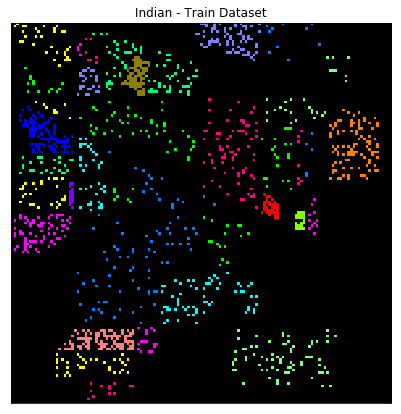

In [98]:
fig = plt.figure(figsize = (15, 7))

ax = fig.add_subplot(1, 1, 1)
ax.imshow(indian_train)
plt.title('Indian - Train Dataset')
plt.xticks([])
plt.yticks([])

plt.show()

-------

# Functions Setup

In [8]:
def img2double(img):
    return np.asarray(img).astype(np.float64)/np.max(np.asarray(img))

In [9]:
def create_index_matrix(img):
    m, n = img.shape
    index_matrix = np.zeros((m, n))
    ind = 1
    
    for j in range(n):
        for i in range(m):
            if img[i, j] > 0:
                index_matrix[i , j] = ind
                ind += 1
            else:
                index_matrix[i, j] = -1
    
    return index_matrix, ind
    
    

In [10]:
def create_spatial_connectivity(img):
    m, n = cv.cvtColor(img, cv.COLOR_BGR2GRAY).shape
    index_matrix, ind = create_index_matrix(cv.cvtColor(img, cv.COLOR_BGR2GRAY))
    
    spatial_connectivity = np.zeros((3, ind - 1))
    
    for i in range(m):
        for j in range(n):
            if i-1 <= 0:
                spatial_connectivity[1, np.int(index_matrix[i,j]-1)] = -1
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = -1
            else:
                spatial_connectivity[1, np.int(index_matrix[i,j]-1)] = index_matrix[i-1,j]
            
            if j-1 <= 0:
                spatial_connectivity[0, np.int(index_matrix[i,j]-1)] = -1
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = -1
            else:
                spatial_connectivity[0, np.int(index_matrix[i,j]-1)] = index_matrix[i, j-1]
                
            if (i-1 > 0) and (j-1 > 0):
                spatial_connectivity[2, np.int(index_matrix[i,j]-1)] = index_matrix[i-1, j-1]
                
    return spatial_connectivity

In [11]:
def create_bin_file(data, filename):
    with open(filename + '.bin', 'wb') as f:
#         f.write(data)
        data.tofile(f)
    f.close()
            
    return '--- Bin File created ---'

In [12]:
def normalize(mat):
    mat -= np.min(mat)
    mat /= np.ptp(mat)
    return mat

In [13]:
def select_features(img, kind = ''):
    if kind == 'pca':
        return img_pca(img)
    else:
        return img_fullfeatures(img)

In [55]:
def img_reshape(img):
    if len(img.shape) == 3:
        m, n, l = img.shape
        return img.reshape(-1, l)
    else:
        m, n = img.shape
        return img.reshape(m * n, 1)

In [53]:
def img_fullfeatures(img):
    img = img_reshape(img).astype(np.float32)   
    return img2double(img).T

In [54]:
def img_pca(img):
    img = img_reshape(img)
    
    img = img2double(img)
    img_cov = np.cov(img.T)
    
    img_std = np.transpose([np.sqrt(np.diag(img_cov))])
    img_std = img_std @ img_std.T
    img_cov = img_cov / img_std
    
    eigen_values, eigen_vectors = np.linalg.eig(img_cov)
    
    select_dim = np.where(eigen_values >= 1)
    
    y = (eigen_vectors @ img.T).T
    y = y[:,select_dim[0]]
    
    y = normalize(y.T).astype(np.float32)
    
    return y    

In [89]:
def img_labels(img):
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    for i in range(np.unique(img).shape[0]):
        img[img == np.unique(img)[i]] = i
    
    return img_reshape(img).astype(np.float32)

-------

# Spatial Connectivity

In [44]:
indian_spatial_connectivity = create_spatial_connectivity(indian_train)

In [45]:
create_bin_file(indian_spatial_connectivity, path_indian_pines + '/Connectivity_Spatial/01_' + filename_indian + '1')

'--- Bin File created ---'

-------

# Features

In [57]:
indian_img_pca = select_features(indian_img, 'pca')
indian_img_pca.shape

(6, 21025)

In [58]:
indian_img_features = select_features(indian_img)
indian_img_features.shape

(200, 21025)

In [47]:
create_bin_file(indian_img_features, path_indian_pines + '/Features/01_30_{}_{}2'.format(indian_img_features.shape[0], filename_indian))

'--- Bin File created ---'

-------

# Labels

In [92]:
indian_labels = img_labels(indian_train)

In [95]:
create_bin_file(indian_labels, path_indian_pines + '/Labels/01_30_{}_{}3'.format(len(np.unique(indian_labels)), filename_indian))

'--- Bin File created ---'

-------

# Train Test Mask